# RAIL Prior

In [1]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as stats
import qp

import nz_prior as nzp

## Load Data

In [2]:
def nz_interpolate(source, n):
    # Extract the zgrid and photo_hists from source_0
    znodes = source['znodes']
    photo_hists = source['photo_hists']
    dz = znodes[1] - znodes[0]

    # Create an interpolation function
    print(znodes.shape, photo_hists.shape)
    interp_func = interp1d(znodes, photo_hists, kind='cubic', axis=0)

    # Define the new zgrid with 1000 nodes
    new_znodes = np.linspace(znodes.min(), znodes.max(), n)
    new_dz = new_znodes[1] - new_znodes[0]
    new_zgrid = np.append([new_znodes[0] - new_dz/2], new_znodes + new_dz/2)

    # Interpolate the photo_hists to the new zgrid
    new_photo_hists = interp_func(new_znodes)
    new_source = {'znodes': new_znodes, 
                  'zgrid': new_zgrid,
                  'photo_hists': new_photo_hists}
    return new_source

def make_qp(ens):
    pzs = ens['photo_hists'].T
    zs_edges = ens['zgrid']
    return qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":pzs})

In [3]:
#method = "bpz"
#source_0 = np.load('/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{}/shear_0.npz'.format(method), allow_pickle=True)
#source_0 = nz_interpolate(source_0, 100)
#q = make_qp(source_0)

In [4]:
def nz_interpolate(zs, nz, n):
    # Extract the zgrid and photo_hists from source_0
    dz = zs[1] - zs[0]

    # Create an interpolation function
    print(zs.shape, nzs.shape)
    interp_func = interp1d(zs, nz, kind='cubic', axis=0)

    # Define the new zgrid with 1000 nodes
    new_znodes = np.linspace(zs.min(), zs.max(), n)
    new_dz = new_znodes[1] - new_znodes[0]
    new_zgrid = np.append([new_znodes[0] - new_dz/2], new_znodes + new_dz/2)

    # Interpolate the photo_hists to the new zgrid
    new_photo_hists = interp_func(new_znodes)
    return new_znodes, new_zgrid, new_photo_hists

In [5]:
dummy = np.load('../tests/dummy.npz')
zs = dummy['zs']
nzs = dummy['pzs']
zs, zs_edges, nzs = nz_interpolate(zs, nzs.T, 100)
q = qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":nzs.T})

(45,) (100, 45)


In [6]:
base = nzp.PriorBase(q)

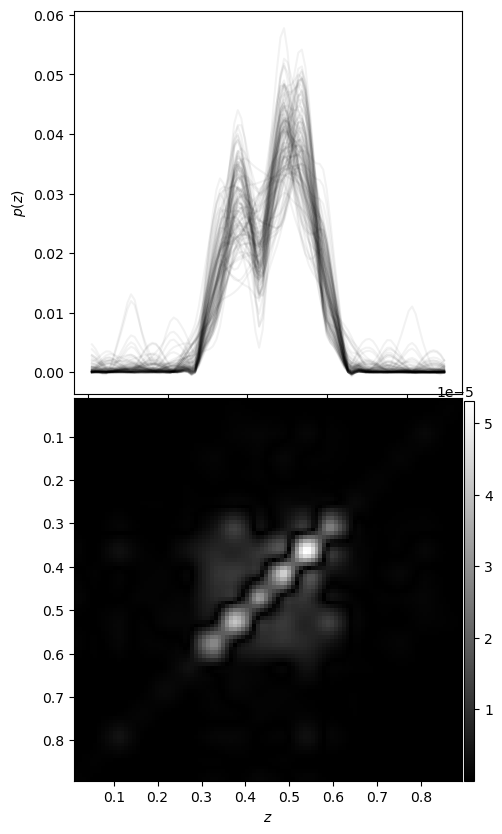

In [7]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(base.z, base.nzs[i], 'k-', alpha=0.05)
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(base.nz_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(base.z), max(base.z), max(base.z), min(base.z)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
plt.show()

# Shifts

In [8]:
shifts = nzp.PriorShifts(q)

In [9]:
pz_fid = [shifts.z, shifts.nz_mean]

In [10]:
shifted_nzs = np.array([nzp.shift_model(pz_fid, shifts.sample_prior()["delta_z"])[1] for i in range(100)])

In [11]:
shifted_cov = np.cov(shifted_nzs.T)
shifted_mean = np.mean(shifted_nzs, axis=0)

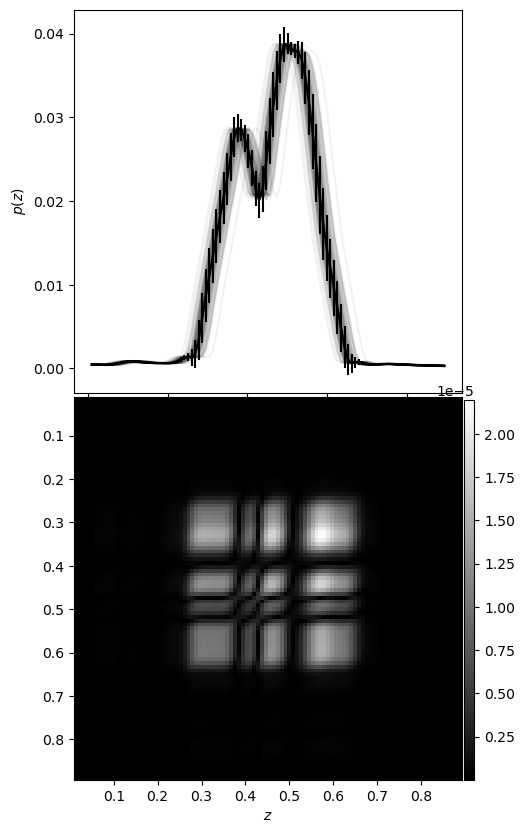

In [12]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    pz = shifted_nzs[i]
    axis[0].plot(shifts.z, pz, 'k-', alpha=0.05)
axis[0].errorbar(shifts.z, shifts.nz_mean, yerr=np.sqrt(np.diag(shifted_cov)), fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(shifted_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(base.z), max(base.z), max(base.z), min(base.z)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/shifts.png')
plt.show()

In [13]:
D_shifts = nzp.Sym_Dkl(shifted_mean, shifted_cov, base.nz_mean, base.nz_cov)


The covariance matrix will be regularized
The covariance matrix will be diagonalized
The covariance matrix will be regularized
The covariance matrix will be diagonalized


# Shifts & Widths

In [14]:
SnW = nzp.PriorShiftsWidths(q)

Removed no burn in


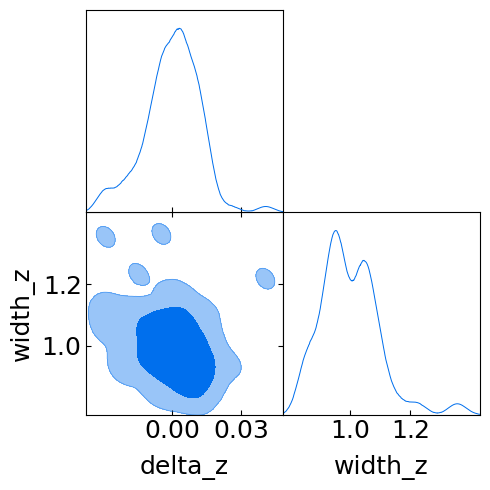

In [15]:
SnW.plot_prior()

In [16]:
SnW.test_prior()

[np.float64(0.6065268804706191), np.float64(0.15715782679538937)]

In [17]:
SnW_nzs = []
for i in range(100):
    prior_sample = SnW.sample_prior()
    shift = prior_sample["delta_z"]
    width = prior_sample["width_z"]
    pz = nzp.shift_and_width_model(pz_fid, [shift, width])[1]
    SnW_nzs.append(pz)
SnW_nzs = np.array(SnW_nzs)

In [18]:
SnW_cov = np.cov(SnW_nzs.T)
SnW_mean = np.mean(SnW_nzs, axis=0)

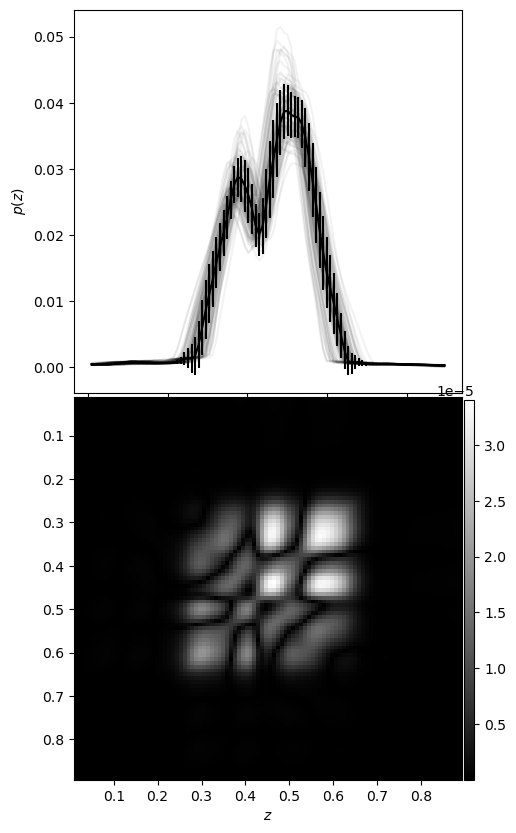

In [19]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(SnW.z, SnW_nzs[i], 'k-', alpha=0.05)
axis[0].errorbar(SnW.z, SnW.nz_mean, yerr=np.sqrt(np.diag(SnW_cov)), fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(SnW_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(base.z), max(base.z), max(base.z), min(base.z)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/gp.png')
plt.show()

In [20]:
D_SnW = nzp.Sym_Dkl(SnW_mean, SnW_cov, base.nz_mean, base.nz_cov)


The covariance matrix will be regularized
The covariance matrix will be regularized
The covariance matrix will be diagonalized


/home/jaimerzp/anaconda3/envs/qp/lib/python3.13/site-packages/nz_prior/utils.py:53: RuntimeWarning: overflow encountered in scalar divide
  T3 = np.log(K_2_det / K_1_det)
/home/jaimerzp/anaconda3/envs/qp/lib/python3.13/site-packages/nz_prior/utils.py:53: RuntimeWarning: divide by zero encountered in log
  T3 = np.log(K_2_det / K_1_det)
/home/jaimerzp/anaconda3/envs/qp/lib/python3.13/site-packages/nz_prior/utils.py:62: RuntimeWarning: invalid value encountered in scalar add
  return 0.5 * (Dkl_12 + Dkl_21)


# GP

In [21]:
gp = nzp.PriorGP(q, n=10)
gp_base = nzp.PriorGP(q)

In [22]:
gp_nzs = np.array([list(gp.sample_prior().values()) for i in range(100)])

The covariance matrix will be regularized


In [23]:
gp_cov = np.cov(gp_nzs.T)
gp_mean = np.mean(gp_nzs, axis=0)

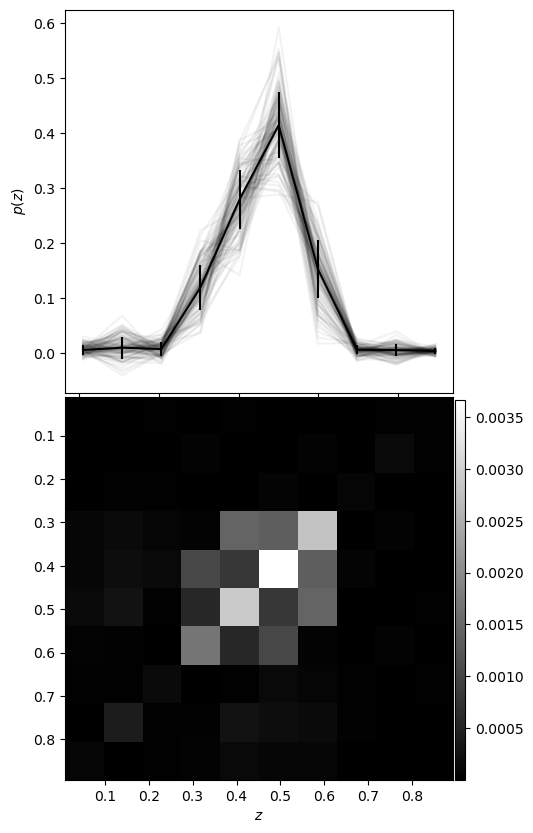

In [24]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(gp.z, gp_nzs[i], 'k-', alpha=0.05)
axis[0].errorbar(gp.z, gp.nz_mean, yerr=np.sqrt(np.diag(gp_cov)), fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(gp_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(base.z), max(base.z), max(base.z), min(base.z)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/gp.png')
plt.show()

In [25]:
D_gp = nzp.Sym_Dkl(base.nz_mean, base.nz_cov, gp_base.nz_mean, gp_base.nz_cov)


The covariance matrix will be regularized
The covariance matrix will be diagonalized
The covariance matrix will be regularized
The covariance matrix will be diagonalized


# Comb

In [26]:
M = 10
comb = nzp.PriorComb(q, ncombs=M)

In [27]:
comb_nzs = []
for i in range(100):
    prior_sample = comb.sample_prior()
    W = np.array([prior_sample[name] for name in comb._get_params_names()])
    pz = nzp.comb_model(pz_fid, W)[1]
    comb_nzs.append(pz)
comb_nzs = np.array(comb_nzs)

In [28]:
comb_cov = np.cov(comb_nzs.T)
comb_mean = np.mean(comb_nzs, axis=0)

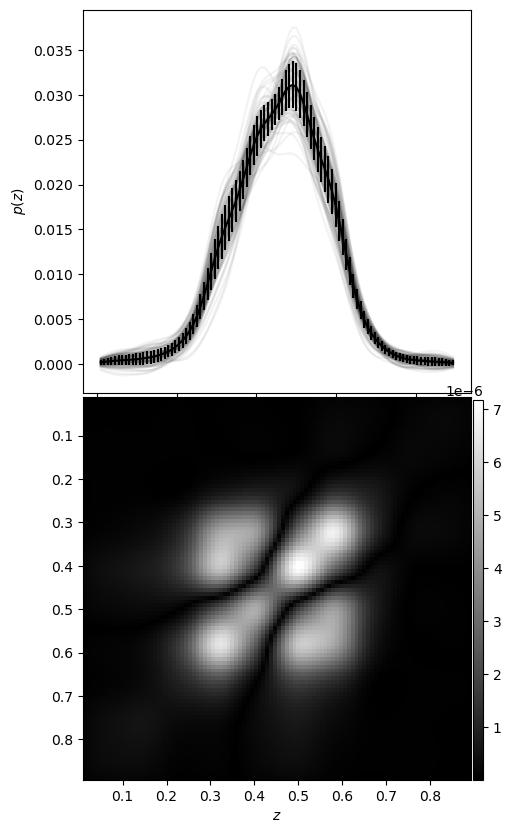

In [29]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(comb.z, comb_nzs[i], 'k-', alpha=0.05)
axis[0].errorbar(comb.z, np.mean(comb_nzs, axis=0),
                 yerr=np.sqrt(np.diag(comb_cov)),
                 fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(comb_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(base.z), max(base.z), max(base.z), min(base.z)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/gp.png')
plt.show()

In [30]:
D_comb = nzp.Sym_Dkl(comb_mean, comb_cov, base.nz_mean, base.nz_cov)

The covariance matrix will be regularized
The covariance matrix will be diagonalized
The covariance matrix will be regularized
The covariance matrix will be diagonalized


# PCA

In [31]:
M = 5
PCA = nzp.PriorPCA(q, npca=M)

In [32]:
pca_nzs = []
nz_fid = [PCA.z, PCA.nz_mean]
for i in range(100):
    prior_sample = PCA.sample_prior()
    W = np.array([prior_sample[name] for name in PCA._get_params_names()])
    pz = nzp.pca_model(nz_fid, W, PCA.eigvecs)[1]
    pca_nzs.append(pz)
pca_nzs = np.array(pca_nzs)

In [33]:
pca_cov = np.cov(pca_nzs.T)
pca_mean = np.mean(pca_nzs, axis=0)

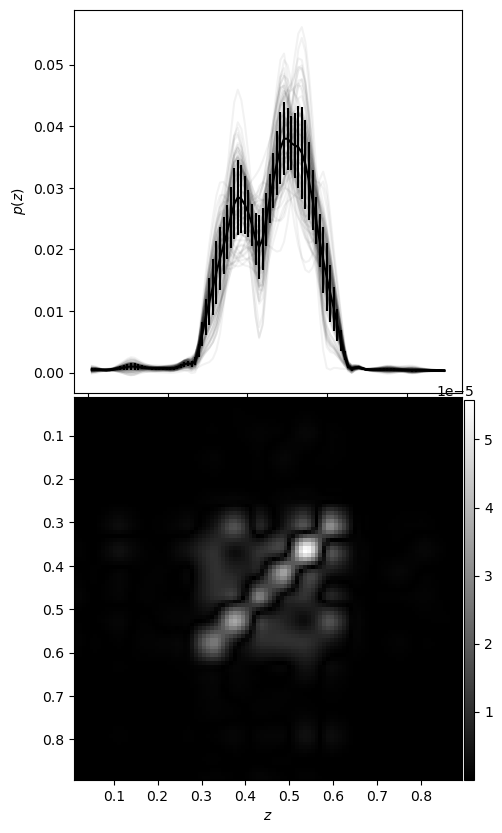

In [34]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(PCA.z, pca_nzs[i], 'k-', alpha=0.05)
axis[0].errorbar(PCA.z, np.mean(pca_nzs, axis=0),
                 yerr=np.sqrt(np.diag(pca_cov)),
                 fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(pca_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(base.z), max(base.z), max(base.z), min(base.z)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/gp.png')
plt.show()

In [35]:
D_PCA = nzp.Sym_Dkl(pca_mean, pca_cov, base.nz_mean, base.nz_cov)

The covariance matrix will be regularized
The covariance matrix will be diagonalized
The covariance matrix will be regularized
The covariance matrix will be diagonalized


# Fourier

In [36]:
N = 10
Fourier = nzp.PriorFourier(q, n=N)

Removed no burn in


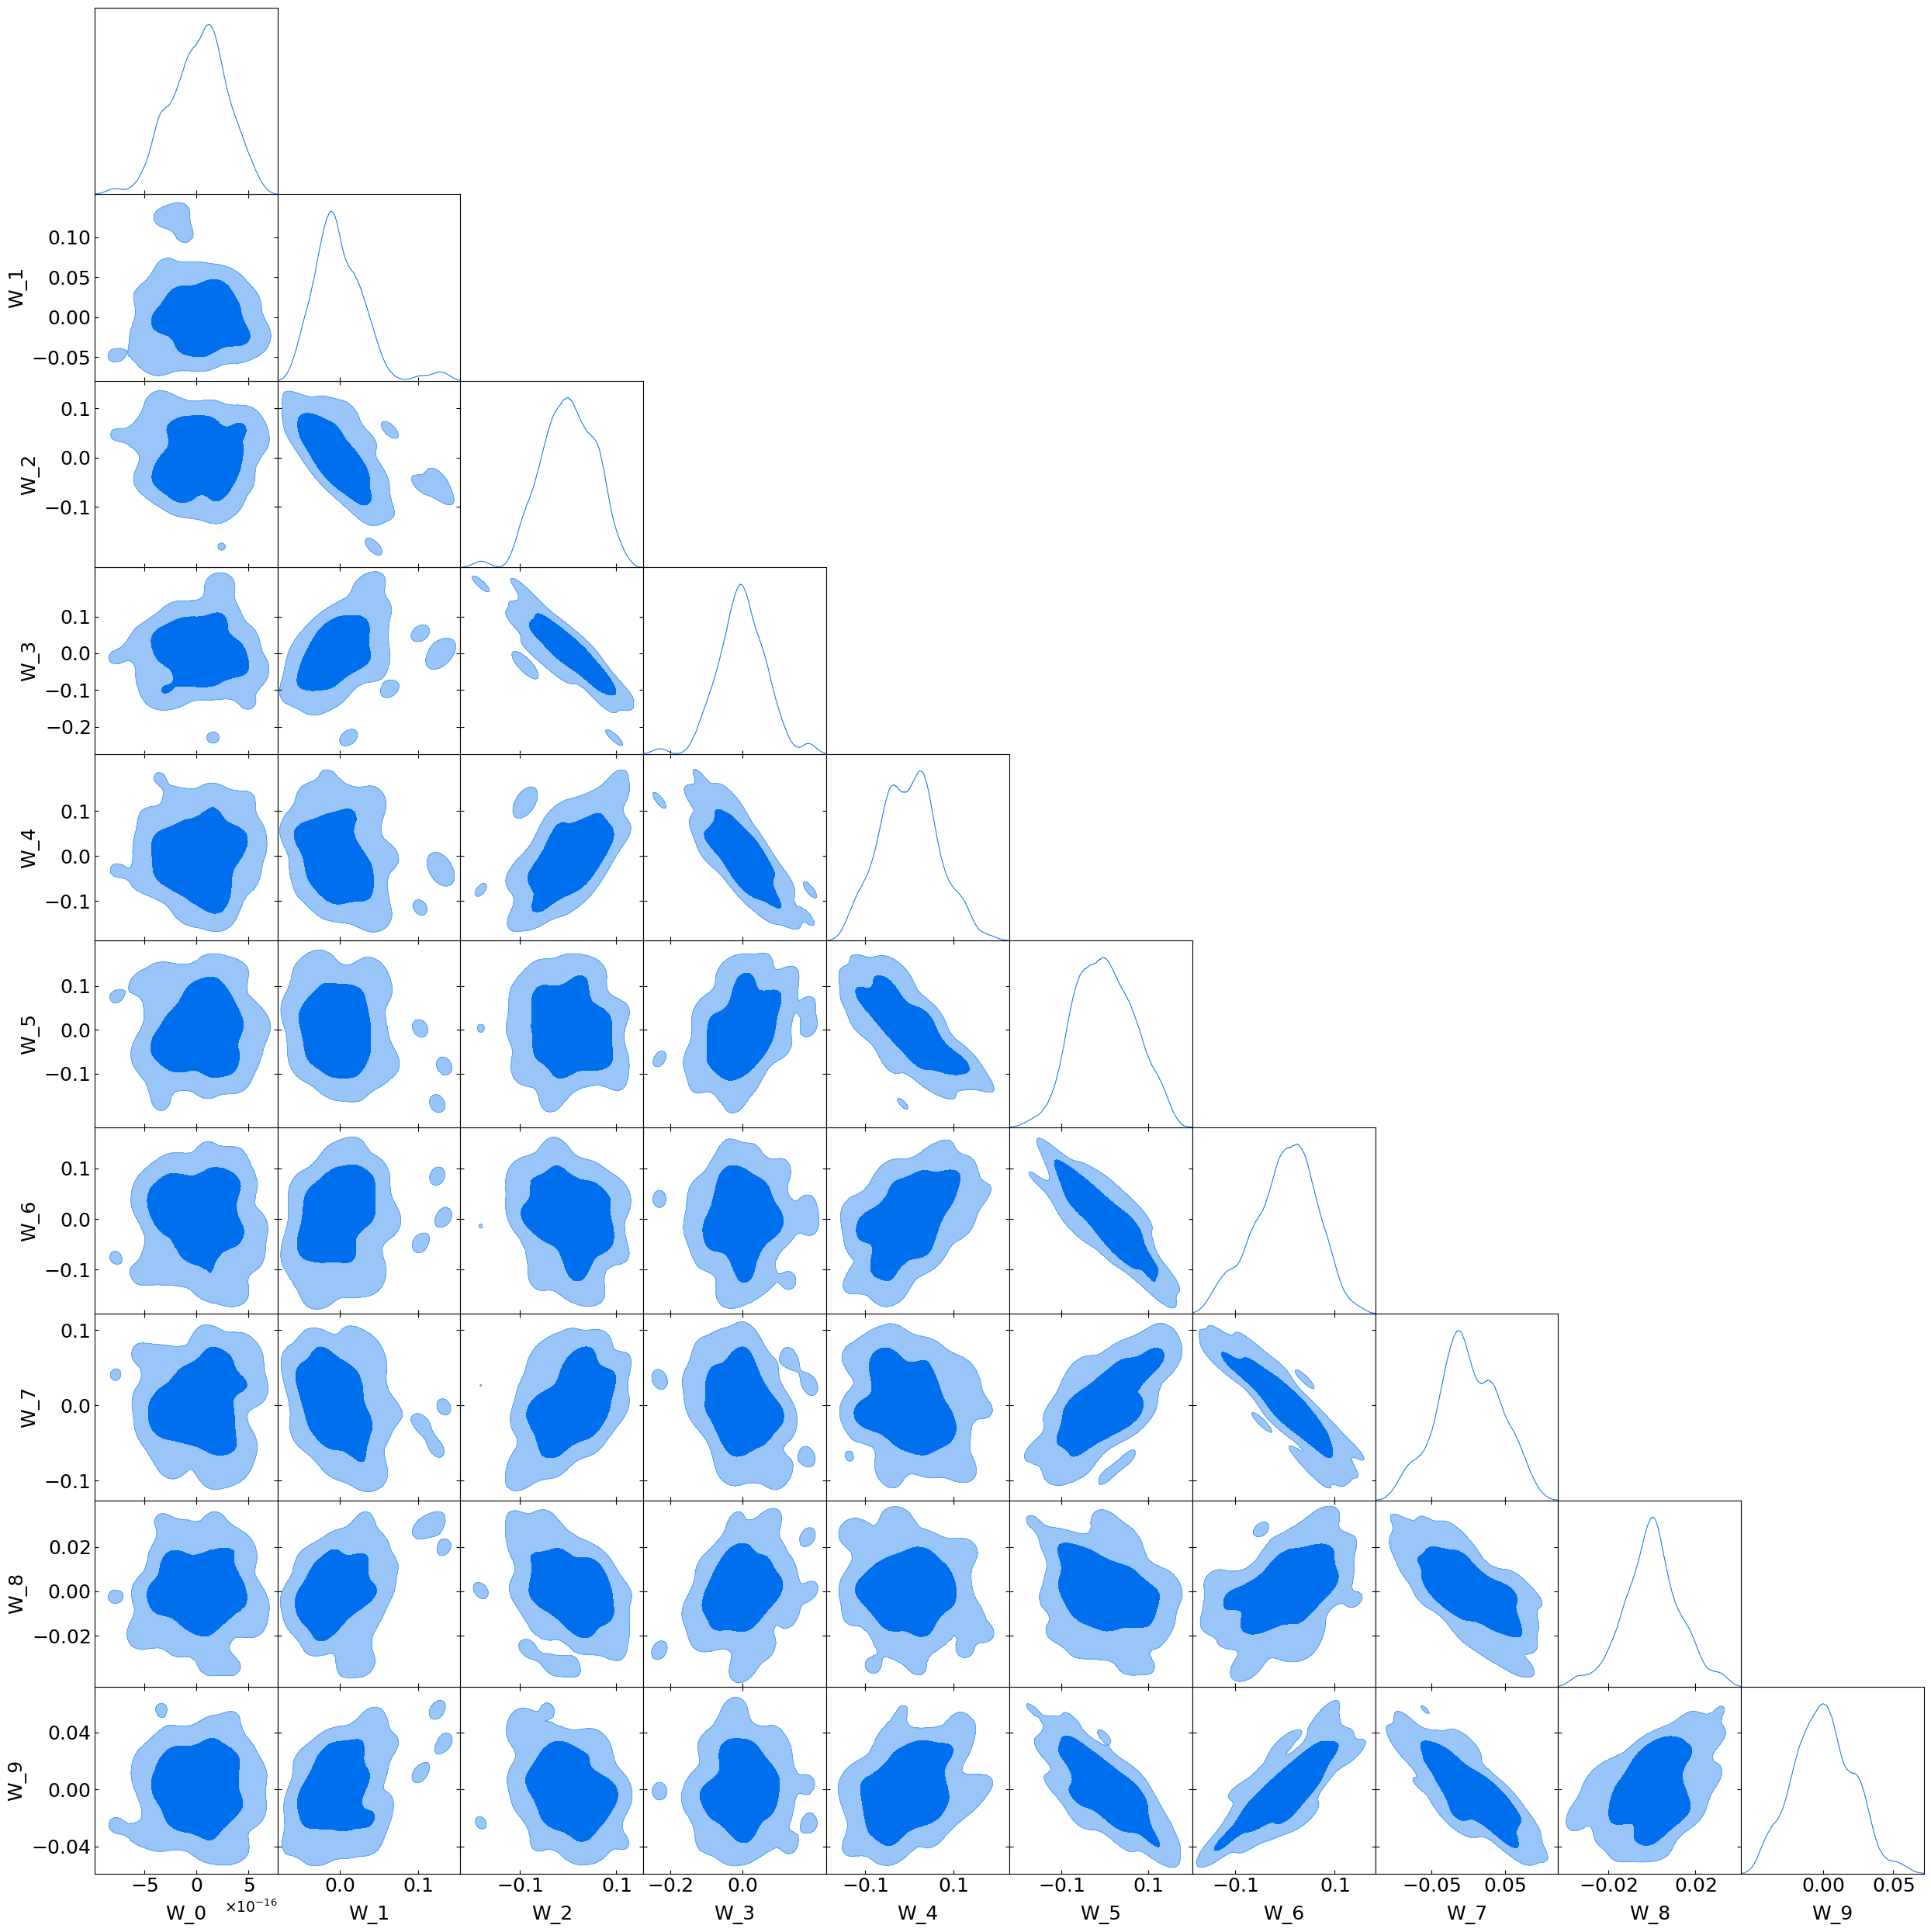

In [37]:
Fourier.plot_prior()

In [38]:
fourier_nzs = []
nz_fid = [Fourier.z, Fourier.nz_mean]
for i in range(100):
    prior_sample = Fourier.sample_prior()
    W = np.array([prior_sample[name] for name in Fourier._get_params_names()])
    pz = nzp.fourier_model(nz_fid, W)[1]
    fourier_nzs.append(pz)
fourier_nzs = np.array(fourier_nzs)

In [39]:
fourier_cov = np.cov(fourier_nzs.T)
fourier_mean = np.mean(fourier_nzs, axis=0)

/home/jaimerzp/anaconda3/envs/qp/lib/python3.13/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jaimerzp/anaconda3/envs/qp/lib/python3.13/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaimerzp/anaconda3/envs/qp/lib/python3.13/site-packages/numpy/ma/core.py:3448: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


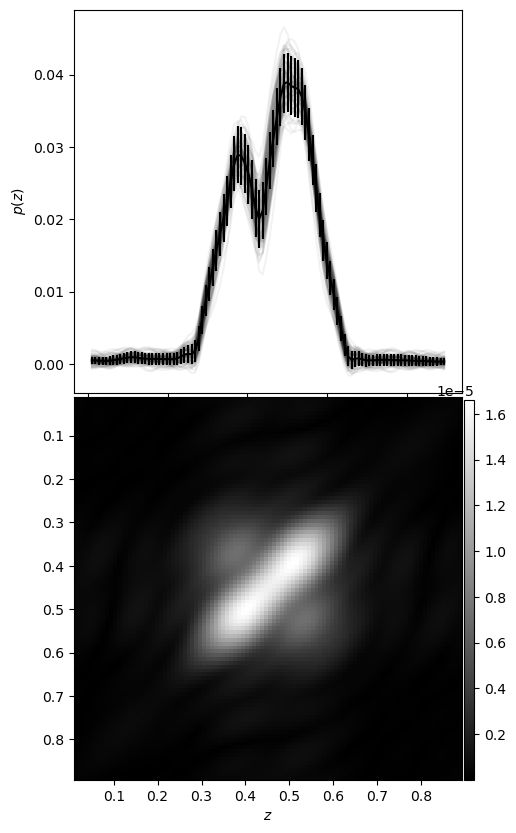

In [40]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(Fourier.z, fourier_nzs[i], 'k-', alpha=0.05)
axis[0].errorbar(Fourier.z, np.mean(fourier_nzs, axis=0),
                 yerr=np.sqrt(np.diag(fourier_cov)),
                 fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(fourier_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(base.z), max(base.z), max(base.z), min(base.z)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/gp.png')
plt.show()

In [41]:
D_Fourier = nzp.Sym_Dkl(fourier_mean, fourier_cov, base.nz_mean, base.nz_cov)

The covariance matrix will be regularized
The covariance matrix will be regularized
The covariance matrix will be diagonalized


/home/jaimerzp/anaconda3/envs/qp/lib/python3.13/site-packages/nz_prior/utils.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  T3 = np.log(K_2_det / K_1_det)
/home/jaimerzp/anaconda3/envs/qp/lib/python3.13/site-packages/nz_prior/utils.py:55: RuntimeWarning: invalid value encountered in scalar multiply
  return 0.5 * (T1 + T2 - T3 - T4)
/home/jaimerzp/anaconda3/envs/qp/lib/python3.13/site-packages/nz_prior/utils.py:53: RuntimeWarning: divide by zero encountered in log
  T3 = np.log(K_2_det / K_1_det)
/home/jaimerzp/anaconda3/envs/qp/lib/python3.13/site-packages/nz_prior/utils.py:62: RuntimeWarning: invalid value encountered in scalar add
  return 0.5 * (Dkl_12 + Dkl_21)


# Comparison


/tmp/ipykernel_89089/3463112939.py:1: RuntimeWarning: divide by zero encountered in log
  plt.bar(np.arange(6), np.log(np.array([D_shifts, D_SnW, D_comb, D_PCA, D_Fourier, D_gp])))
/home/jaimerzp/anaconda3/envs/qp/lib/python3.13/site-packages/matplotlib/transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaimerzp/anaconda3/envs/qp/lib/python3.13/site-packages/matplotlib/transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


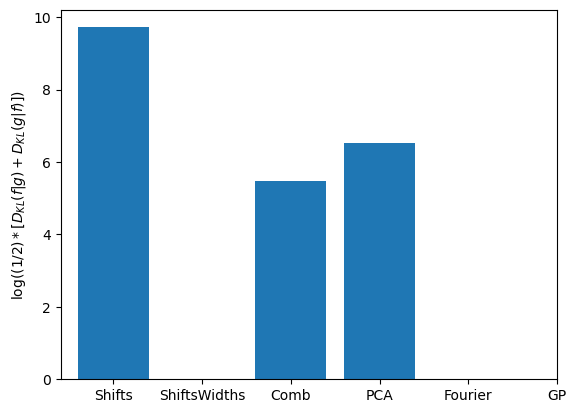

In [42]:
plt.bar(np.arange(6), np.log(np.array([D_shifts, D_SnW, D_comb, D_PCA, D_Fourier, D_gp])))
plt.xticks(np.arange(6), ['Shifts', 'ShiftsWidths', 'Comb', 'PCA', 'Fourier', 'GP'])
plt.ylabel(r'$\log ((1/2)*[D_{KL}(f|g)+D_{KL}(g|f)])$')
plt.show()